# Time Sequence Prediction

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
N = 100
L = 1000
T = 20

In [4]:
x = np.empty((N, L), np.float32)
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N, 1)

In [5]:
y = np.sin(x/1.0/T).astype(np.float32)

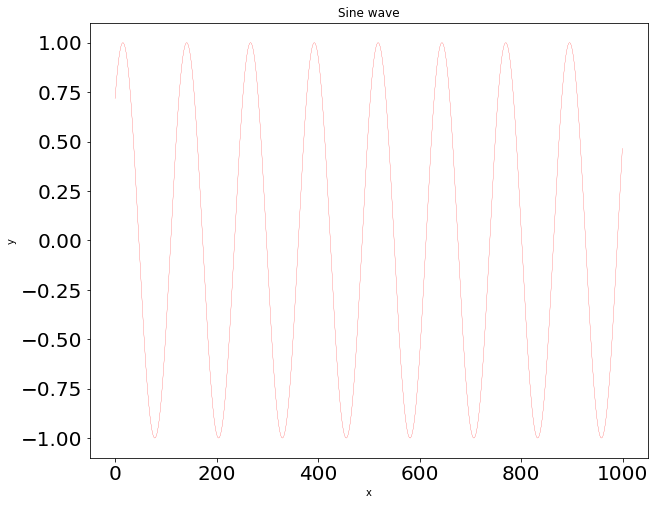

In [28]:
plt.figure(figsize=(10, 8))
plt.title("Sine wave")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(np.arange(x.shape[1]), y[0,:], 'r', linewidth=0.2)
# plt.show()

In [29]:
class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden=51):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.lstm1 = nn.LSTMCell(1, self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)

    def forward(self, x, future=0):
        outputs = []
        n_samples = x.size(0)

        h_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)

        for input_t in x.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)

        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)

        outputs = torch.cat(outputs, dim=1)
        return outputs

Step 0
loss 0.509094774723053
loss 0.5010741353034973
loss 0.48176392912864685
loss 0.46952247619628906
loss 0.41846412420272827
loss 2.0025241374969482
loss 0.2925378084182739
loss 0.1965901106595993
loss 15.828195571899414
loss 0.2306929975748062
loss 0.03705410286784172
loss 0.025590967386960983
loss 0.0244287196546793
loss 0.02415122091770172
loss 0.02376832626760006
loss 0.02301895245909691
loss 0.02157171443104744
loss 0.018881825730204582
loss 0.014073497615754604
loss 0.007294246461242437
test loss 0.0057325176894664764
Step 1
loss 0.005614017602056265
loss 0.004827527329325676
loss 0.003683436429128051
loss 0.0029647115152329206
loss 0.0018387025920674205
loss 0.0011048289015889168
loss 0.0009849031921476126
loss 0.0009630508720874786
loss 0.00092848896747455
loss 0.0008659529848955572
loss 0.0007886937237344682
loss 0.0007107059354893863
loss 0.0006670538568869233
loss 0.0006508816150017083
loss 0.0006433905218727887
loss 0.0006336829392239451
loss 0.0006153882131911814
loss 

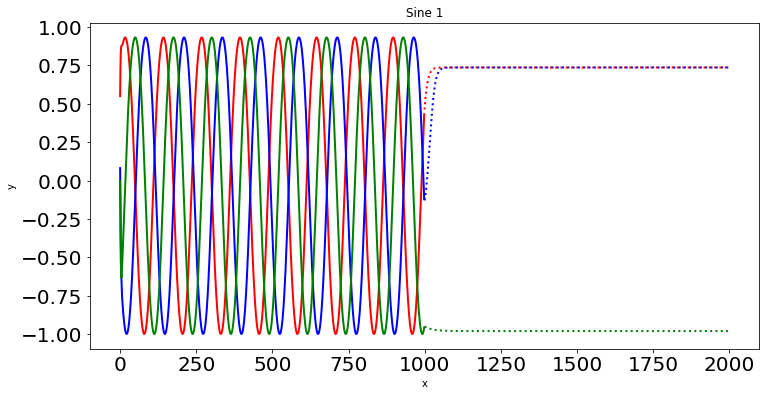

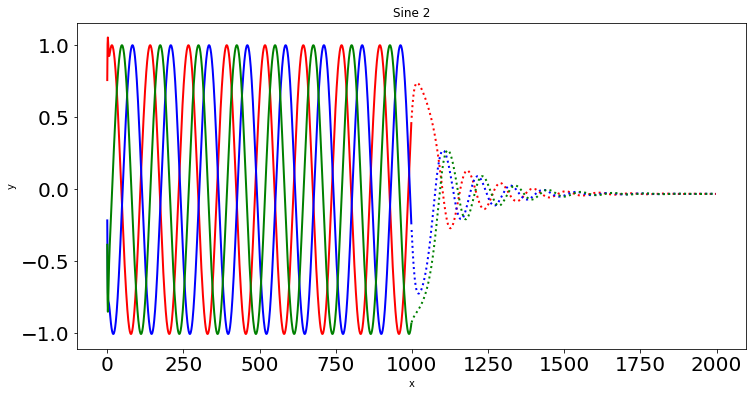

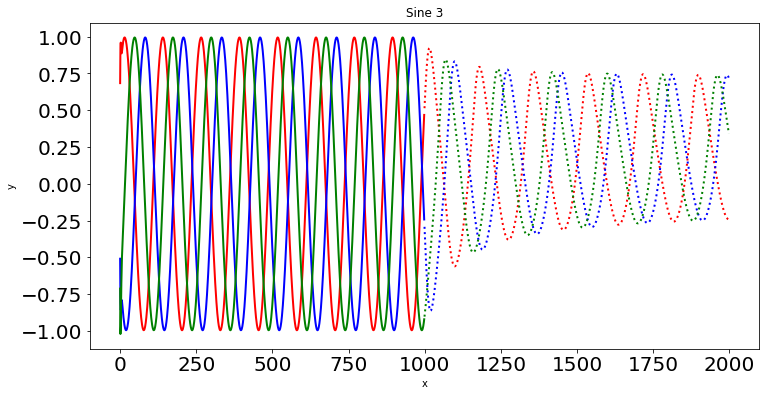

In [ ]:
if __name__ == "__main__":
    train_input = torch.from_numpy(y[3:, :-1])
    train_target = torch.from_numpy(y[3:, 1:])
    test_input = torch.from_numpy(y[:3, :-1])
    test_target = torch.from_numpy(y[:3, 1:])

    model = LSTMPredictor()
    criterion = nn.MSELoss()
    optimizer = optim.LBFGS(model.parameters(), lr=0.8)

    n_steps = 10
    for i in range(n_steps):
        print("Step", i)

        def closure():
            optimizer.zero_grad()
            out = model(train_input)
            loss = criterion(out, train_target)
            print("loss", loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)

        with torch.no_grad():
            future = 1000
            pred = model(test_input, future=future)
            loss = criterion(pred[:, :-future], test_target)
            print("test loss", loss.item())
            y = pred.detach().numpy()

        plt.figure(figsize=(12, 6))
        plt.title(f"Sine {i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        n = train_input.shape[1]

        def draw(y_i, color):
            plt.plot(np.arange(n), y_i[:n], color, linewidth=2.0)
            plt.plot(np.arange(n, n+future), y_i[n:], color + ":", linewidth=2.0)

        draw(y[0], 'r')
        draw(y[1], 'b')
        draw(y[2], 'g')
        plt.show()